* radius is around 1000m

Tips
* Offset: camera center is vehicle center.  Use vehicle center to claculate distance from center of lane
* implement "reset" feature in case lines are not detected in a few consecutive frames
* smoothing of lines
* Rubric: https://review.udacity.com/#!/rubrics/571/view


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob

%matplotlib inline

DEBUGMODE = 1

img_path = './test_images/'
out_img_path='./output_images/'

In [2]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in meters
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def update_radius_of_curvature(self, newrad):
        oldrad=self.radius_of_curvature

        if (oldrad == None):
               intval = newrad
        else:        
            alpha=0.96
            intval = alpha*oldrad + (1-alpha)*newrad
    
        self.radius_of_curvature = intval

In [3]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255), debug=DEBUGMODE):
    """
    Receives RGB image
    
    Returns the binary image
    """
    # Calculate directional gradient
    thresh_min=thresh[0]
    thresh_max=thresh[1]

    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if (orient == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Apply threshold
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    # 6) Return this mask as your binary_output image
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255), debug=DEBUGMODE):
    """
    Receives RGB image
    Calculates and applies threshold
    Returns the binary image
    """
    # Calculate gradient magnitude
    thresh_min=mag_thresh[0]
    thresh_max=mag_thresh[1]

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_mag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_mag/np.max(abs_mag))
    # Apply threshold
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    # 6) Return this mask as your binary_output image
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2), debug=DEBUGMODE):
    """
    Receives RGB image
    Applies threshold
    Returns the binary image
    """
    # Calculate gradient direction
    thresh_min=thresh[0]
    thresh_max=thresh[1]
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    abs_mag = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_gradient = np.arctan2(abs_sobely, abs_sobelx)
    # Apply threshold
    # 5) Create a binary mask where direction thresholds are met
    sxbinary = np.zeros_like(dir_gradient)
    sxbinary[(dir_gradient >= thresh_min) & (dir_gradient <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

def hls_select(img, sthresh=(0, 255), debug=DEBUGMODE):
    """
    Receives RGB image
    Applies threshold on the S-channel of HLS (hue, lightness, and saturation)
    Returns the binary image
    """
    sthresh_min = sthresh[0]
    sthresh_max = sthresh[1]
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Grab the s-channel
    s_channel = hls[:,:,-1]    
    # 3) Apply a threshold to the S channel
    sbinary_output = np.zeros_like(s_channel)
    sbinary_output[(s_channel > sthresh_min) & (s_channel <= sthresh_max)] = 1
    # 4) Return a binary image of threshold result
    return sbinary_output

def hsv_select(img, vthresh=(0, 255), debug=DEBUGMODE):
    """
    Receives RGB image
    Applies threshold on the V-channel of HSV (hue, saturation, and value)
    Returns the binary image
    """
    vthresh_min = vthresh[0]
    vthresh_max = vthresh[1]
    # 1) Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # 2) Grab the v-channel
    v_channel = hsv[:,:,-1]
    # 3) Apply a threshold to the V channel
    vbinary_output = np.zeros_like(v_channel)
    vbinary_output[(v_channel > vthresh_min) & (v_channel <= vthresh_max)] = 1
    # 4) Return a binary image of threshold result
    return vbinary_output

def color_select(img, sthresh=(0, 255), vthresh=(0, 255), debug=DEBUGMODE):

    sbinary = hls_select(img, sthresh=sthresh)
    vbinary = hsv_select(img, vthresh=vthresh)
    
    binary_output = np.zeros_like(sbinary)
    binary_output[(sbinary==1) & (vbinary==1)] = 1
    
    # 3) Return a binary image of threshold result
    return binary_output

def mask(img, debug=DEBUGMODE):
    """
    This function 
       receives the RGB image
    1) Converts to grayscale
    2) calculates the ROI mask
    3) applies an ROI mask
    4) Returns the binary mask
    """
    # 1) Convert to gray
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Calculate ROI mask
    height, width = gray.shape
    ROIvertices = np.array([[(0, height),                        # bottom left (x, y)
                          (width/2, height/1.8),                 # top left
                          (width/2, height/1.8),                 # top right
                          (width, height)]], dtype=np.int32)     # bottom right      

    # 3) Apply the ROI mask
    # Define blank mask to start with
    mask = np.zeros_like(gray)
    # Fill pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, ROIvertices, 255)

    mask_binary = np.zeros_like(mask)
    mask_binary[mask==255] = 1

    # 4) Return the binary mask
    return mask_binary

In [4]:
def get_edges(img, debug=DEBUGMODE):
    """
    This function 
    1) receives the RGB image
    2) performs the following processing steps on it.
        * color and gradient thresholding
        * applies an ROI mask
    3) returns the processed binary image
    """
    
    # Choose a Sobel kernel size
    ksize = 9 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(30, 100))
    if(debug==1):
        cv2.imwrite(out_img_path+'gradx.jpg',255*gradx)

    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(30, 100))
    if(debug==1):
        cv2.imwrite(out_img_path+'grady.jpg',255*grady)

    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(50, 255)) #100
    if(debug==1):
        cv2.imwrite(out_img_path+'magbin.jpg', 255*mag_binary)

    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))
    if(debug==1):
        cv2.imwrite(out_img_path+'dir_binary.jpg', 255*dir_binary)

    color_binary = color_select(img, sthresh=(100, 255), vthresh=(100, 255))
    if(debug==1):
        cv2.imwrite(out_img_path+'color_binary.jpg', 255*color_binary)
    
    mask_binary = mask(img)
    if(debug==1):
        cv2.imwrite(out_img_path+'mask_binary.jpg', 255*mask_binary)
    
    combined = np.zeros_like(dir_binary)
    #combined[((((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))) & (mask_binary==1))] = 1
    combined[((((mag_binary == 1) & (dir_binary == 1))| (color_binary==1)) & (mask_binary==1))] = 1
    
    if(debug==1):
        cv2.imwrite(out_img_path+'combined.jpg', 255*combined)

    return combined

In [5]:
def perspective_transform(img):
    """
    This function
    1) receives the binary image
    2) sets up the source and destination points
    3) performs transform to bird's eye view
    4) returns birdseye_image, transform and inverse transform matrices
    """
    img_size = (img.shape[1],img.shape[0])
    # image values estimated from: straight_lines1.jpg
    src_bottom_left = [256, 684]
    src_top_left = [597,449]
    src_bottom_right = [1035,673]
    src_top_right = [683,449]
    src = np.float32([src_bottom_left,src_top_left,src_top_right,src_bottom_right])
    
    # Set up the destination
    dest_x_left = 400  # Guessed.  Might want to change for tighter curves
    dest_x_right = 800 # Guessed.  Might want to change for tighter curves
    dest_bottom_left = [dest_x_left, img_size[1]]
    dest_top_left = [dest_x_left,0]
    dest_bottom_right = [dest_x_right,img_size[1]]
    dest_top_right = [dest_x_right,0]
    dest = np.float32([dest_bottom_left,dest_top_left,dest_top_right,dest_bottom_right])
    
    M = cv2.getPerspectiveTransform(src,dest)
    Minv = cv2.getPerspectiveTransform(dest,src)
    
    b_birdseye = cv2.warpPerspective(img,M,img_size, flags=cv2.INTER_LINEAR)

    return b_birdseye, M, Minv

In [6]:
def find_lane_boundary(img):
    """
    Receives a binary image
    Estimates existance of lane boundaries
    Returns an image with the lane boundaries painted
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((np.zeros_like(img), img, img))*255
    out_img = out_img.astype(np.uint8, copy=False)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #===============================================================
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3/72 # meters per pixel in y dimension
    xm_per_pix = 3.7/395 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    #===============================================================
    
    # Generate x and y values for plotting
    #ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img, left_fit, right_fit, left_fit_cr, right_fit_cr

In [7]:
def coefs_to_radius(fit_cr, debug=DEBUGMODE):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3/72 # meters per pixel in y dimension
    xm_per_pix = 3.7/395 # meters per pixel in x dimension
    
    ploty = np.linspace(0, 719, num=720)
    y_eval = np.max(ploty)
    
    # Calculate the new radii of curvature
    #left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    #right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

    if(debug==1):
        # Now our radius of curvature is in meters
        print(curverad, 'm')

    #return left_curverad, right_curverad
    return curverad

In [8]:
def estimate_ego_lateral_position(left_fit, right_fit):
    '''
    Offset.
    You can assume the camera is mounted at the center of the car, such that the lane center is the 
    midpoint at the bottom of the image between the two lines you've detected. The offset of the 
    lane center from the center of the image (converted from pixels to meters) is your distance from 
    the center of the lane. 
    '''
    y=720 # bottom of image
       
    left_fitx = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
    right_fitx = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]    

    return (left_fitx + right_fitx) /2

In [9]:
def inv_perspective_transform(c_img, left_fit, right_fit, Minv):
    '''
    c_img:       color undistorted image
    left_fit:  polynomial coefficients, left line
    right_fit: polynomial coefficients, right line
    '''
    img = c_img[:,:,1]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] ) #(0, 719, 720)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(c_img, 1, newwarp, 0.3, 0)

    return result

C:\Users\Debbie\Anaconda3\envs\sdc_term1\lib\site-packages\ipykernel\__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


8705.2478952 m
3113.06527096 m
2847.83096275 m
3710.51822462 m
4974.05718971 m
447.964681293 m
320.571251562 m
354.062687373 m
404.319514982 m
546.020332404 m
988.184046687 m
574.918180466 m
808.65207964 m
273.595491068 m
747.119659796 m
1030.10177367 m


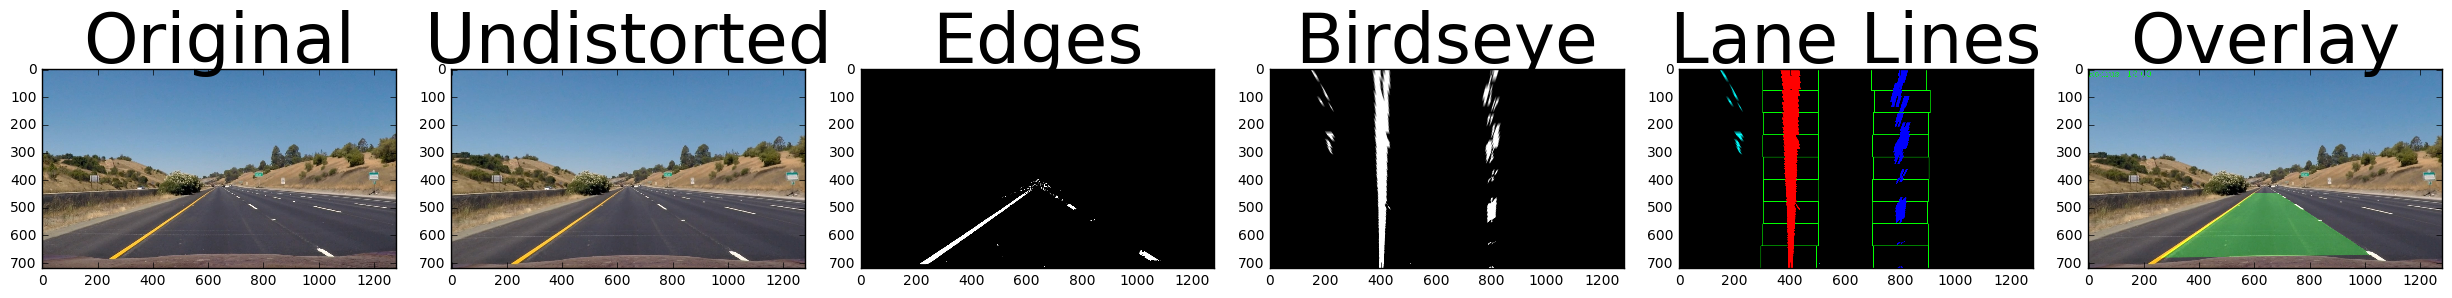

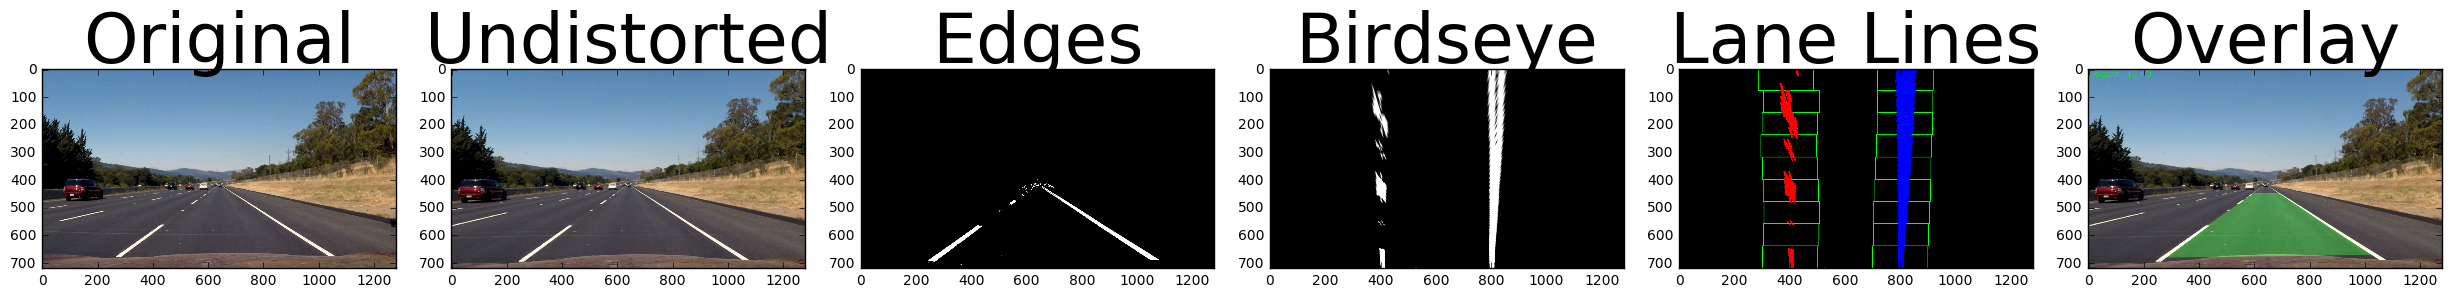

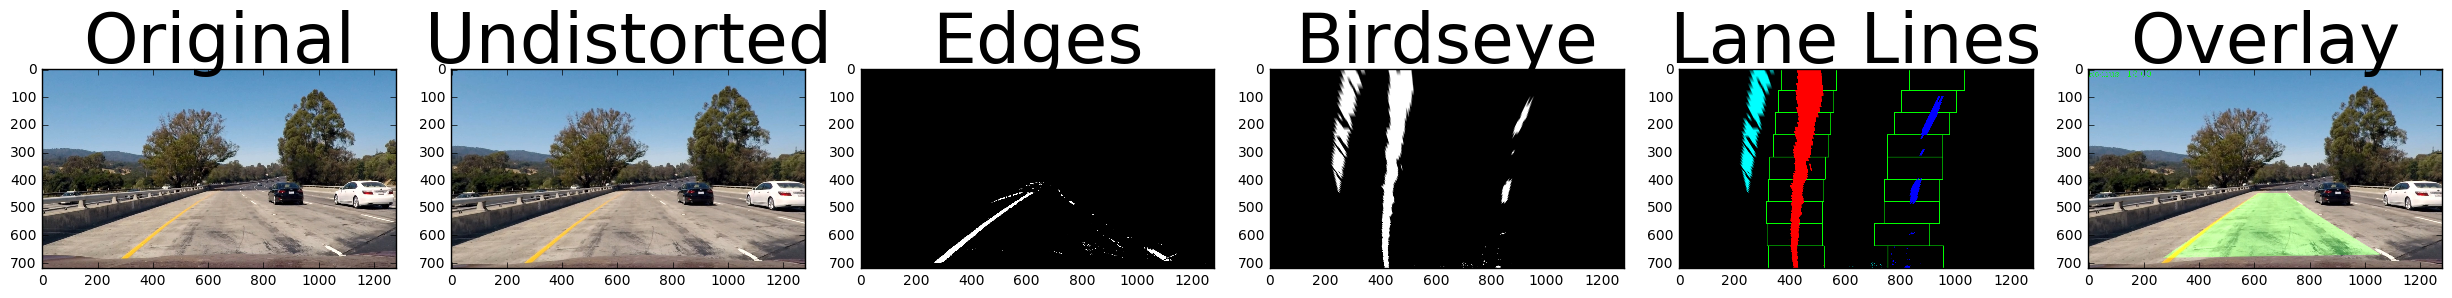

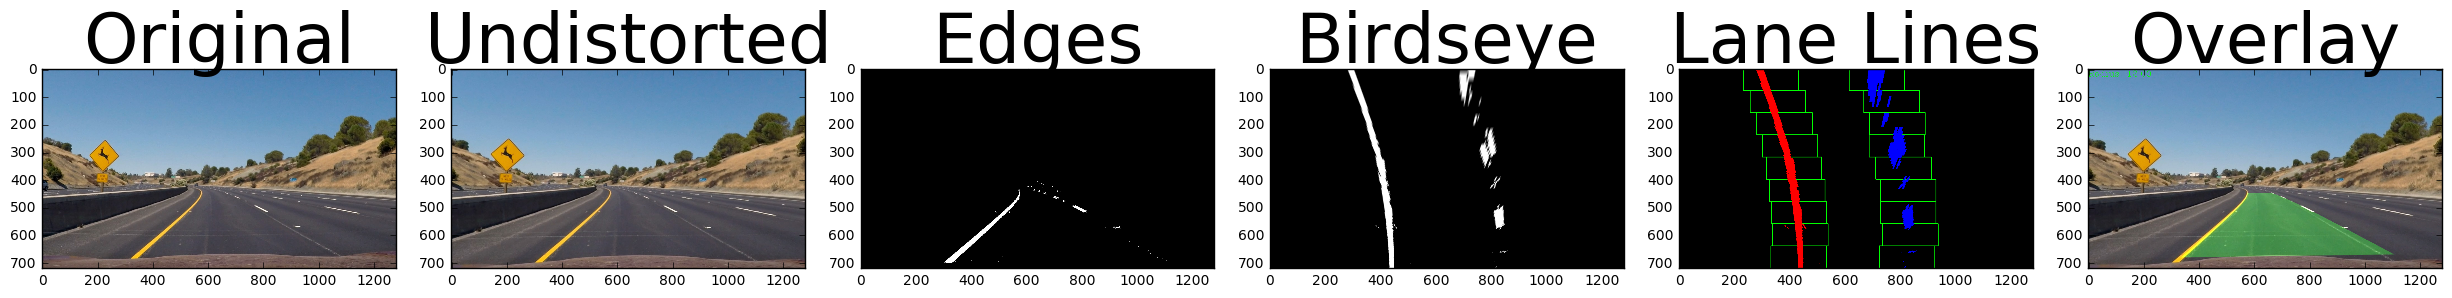

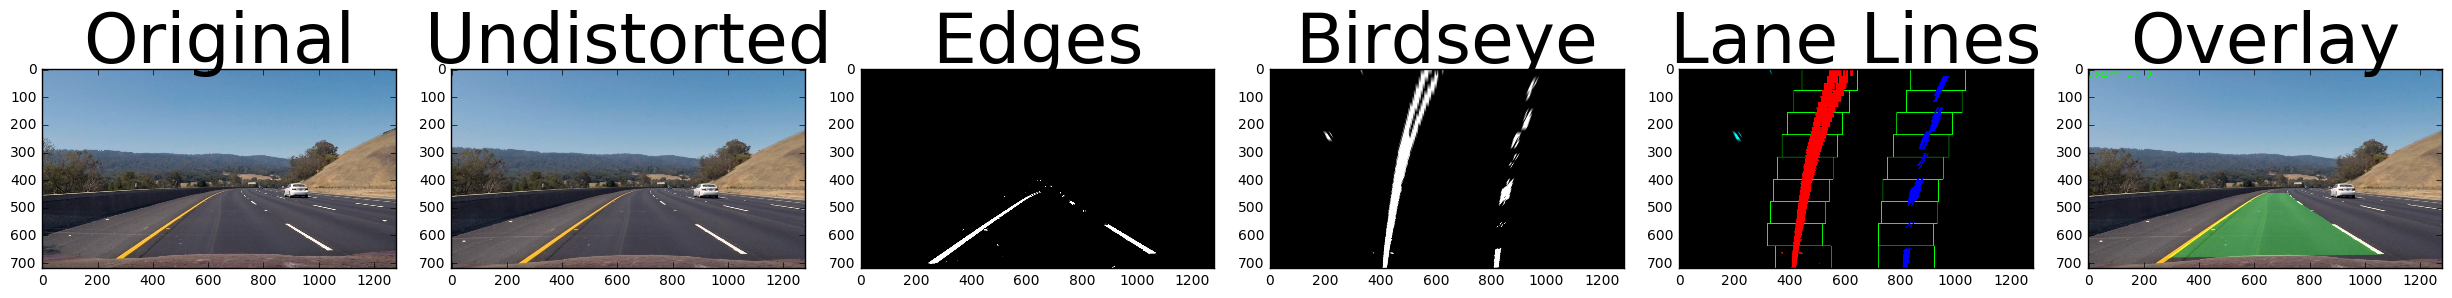

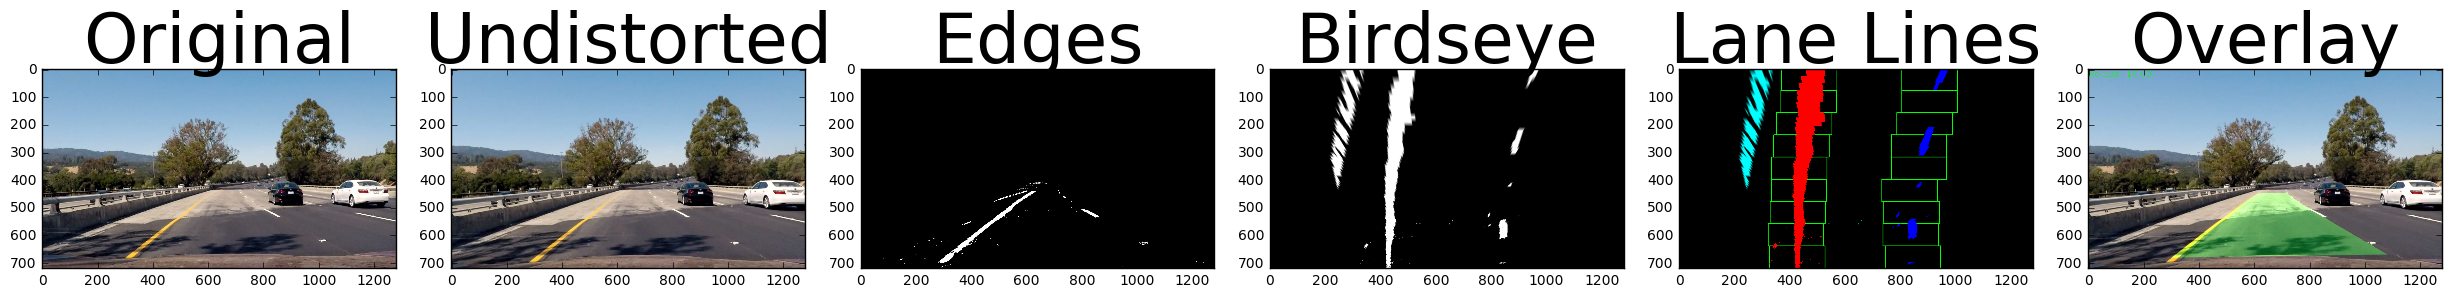

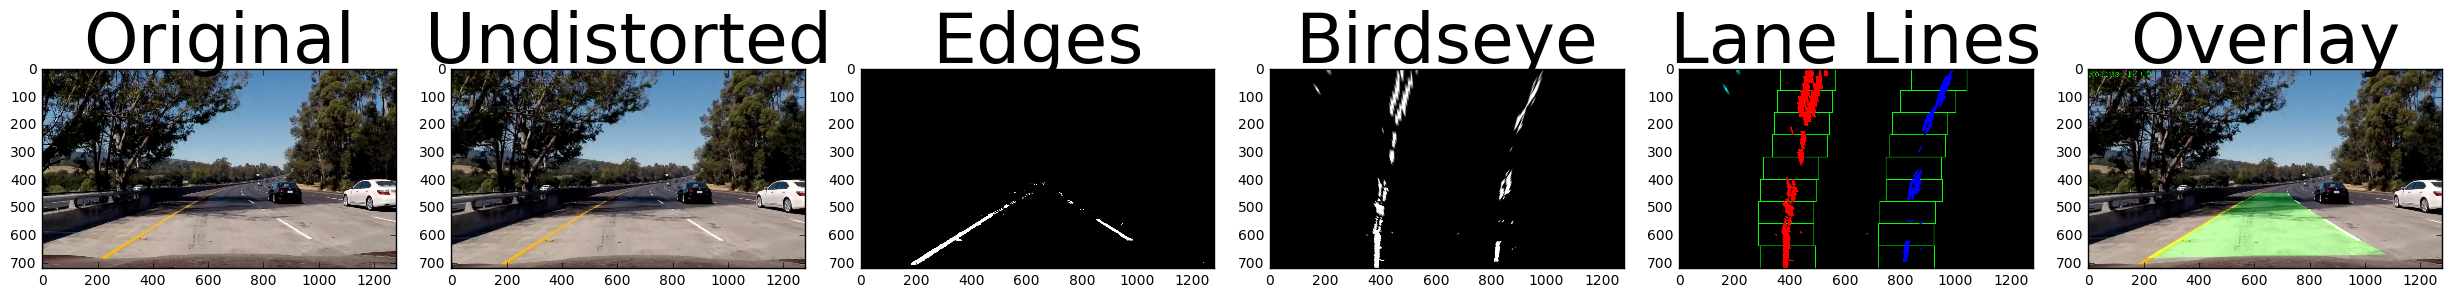

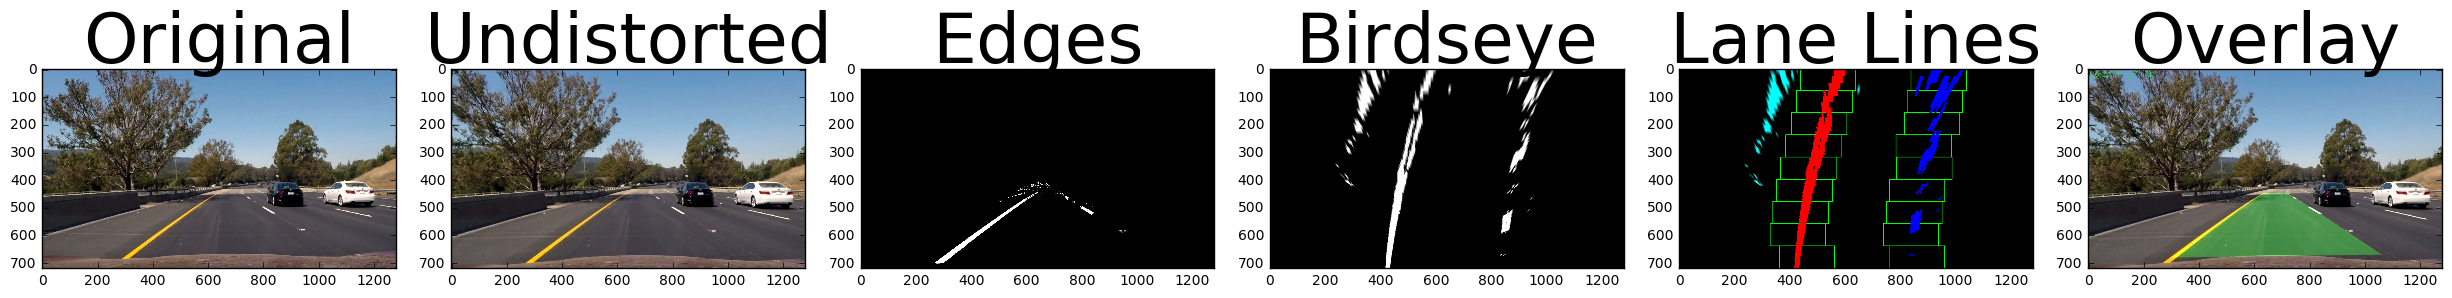

In [19]:
# get the stored undistortion matrices
dist_pickle = pickle.load(open( "dist_pickle.p", "rb" ))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

images = glob.glob(img_path+'*.jpg')

debug = DEBUGMODE

leftline = Line()
rightline = Line()

for fname in images:
    c_img_raw = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB) #CAUTION: cv2.imread reads in BGR

    # Undisttort the image
    c_img_undist = cv2.undistort(c_img_raw, mtx, dist, None, mtx)
    if(debug==1):
        cv2.imwrite(out_img_path+'undist.jpg',cv2.cvtColor(c_img_undist, cv2.COLOR_RGB2BGR))
        
    # process the image to get the Edges
    b_edges = get_edges(c_img_undist)
    if(debug==1):
        
        cv2.imwrite(out_img_path+'edges.jpg',255*b_edges)

    # Perspective Transform
    b_birdseye, M, Minv = perspective_transform(b_edges)
    if(debug==1):
        cv2.imwrite(out_img_path+'birdseye.jpg',255*b_birdseye)
    
    # Use birdseye to find_lane_lines
    c_img_lane, lfit, rfit, lfit_m, rfit_m = find_lane_boundary(b_birdseye)
    if(debug==1):
        cv2.imwrite(out_img_path+'lanelines.jpg',cv2.cvtColor(c_img_lane, cv2.COLOR_RGB2BGR))

    leftline.update_radius_of_curvature(coefs_to_radius(lfit_m))
    rightline.update_radius_of_curvature(coefs_to_radius(rfit_m))
    
    #estimate_ego_lateral_position(lfit_m, rfit_m)

    # Overlay the lane to the undistorted image
    c_final = inv_perspective_transform(c_img_undist, lfit, rfit, Minv)   
    # Annotate the image
    cv2.putText(c_final, 'Radius: {0:.2f}'.format(12), org=(0, 30), fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=1, color=(0,255,0))     
    if(debug==1):
        cv2.imwrite(out_img_path+'final.jpg',cv2.cvtColor(c_final, cv2.COLOR_RGB2BGR))

    if(debug==1):
        # Plot the result
        f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(c_img_raw)
        ax1.set_title('Original', fontsize=50)

        ax2.imshow(c_img_undist)
        ax2.set_title('Undistorted', fontsize=50)
    
        ax3.imshow(b_edges, cmap='gray')
        ax3.set_title('Edges', fontsize=50)
    
        ax4.imshow(b_birdseye, cmap='gray')
        ax4.set_title('Birdseye', fontsize=50)
    
        ax5.imshow(c_img_lane)
        ax5.set_title('Lane Lines', fontsize=50)  

        ax6.imshow(c_final)
        ax6.set_title('Overlay', fontsize=50)  
    
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

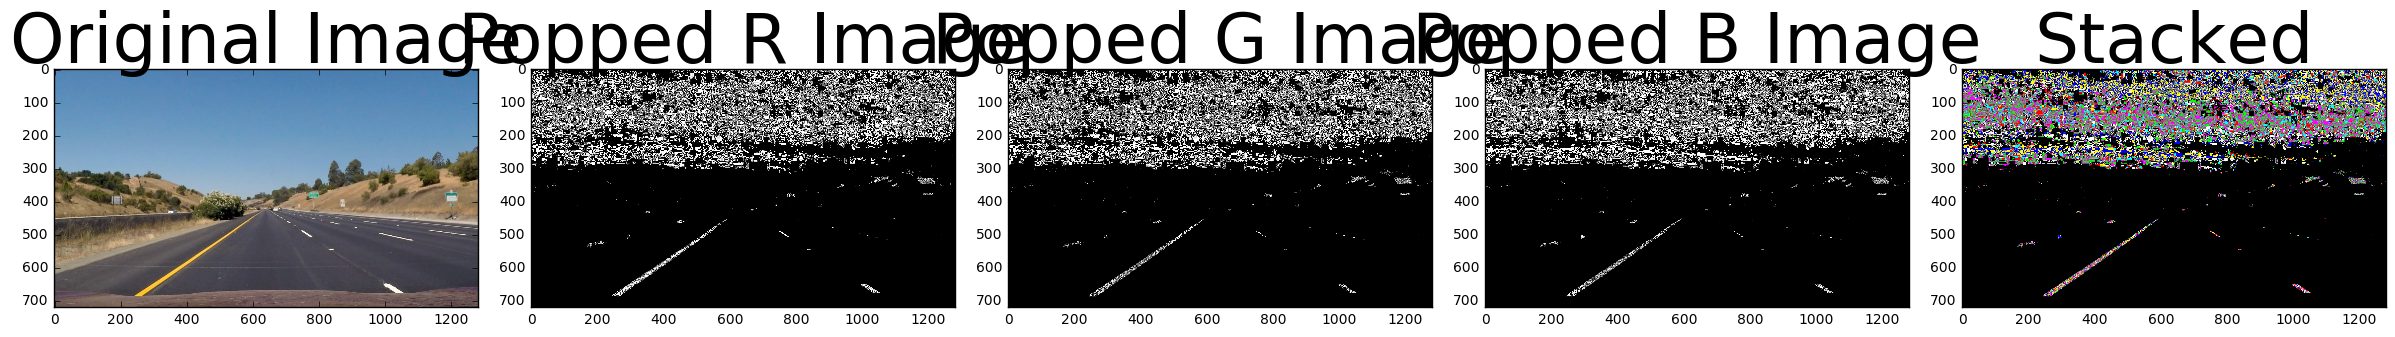

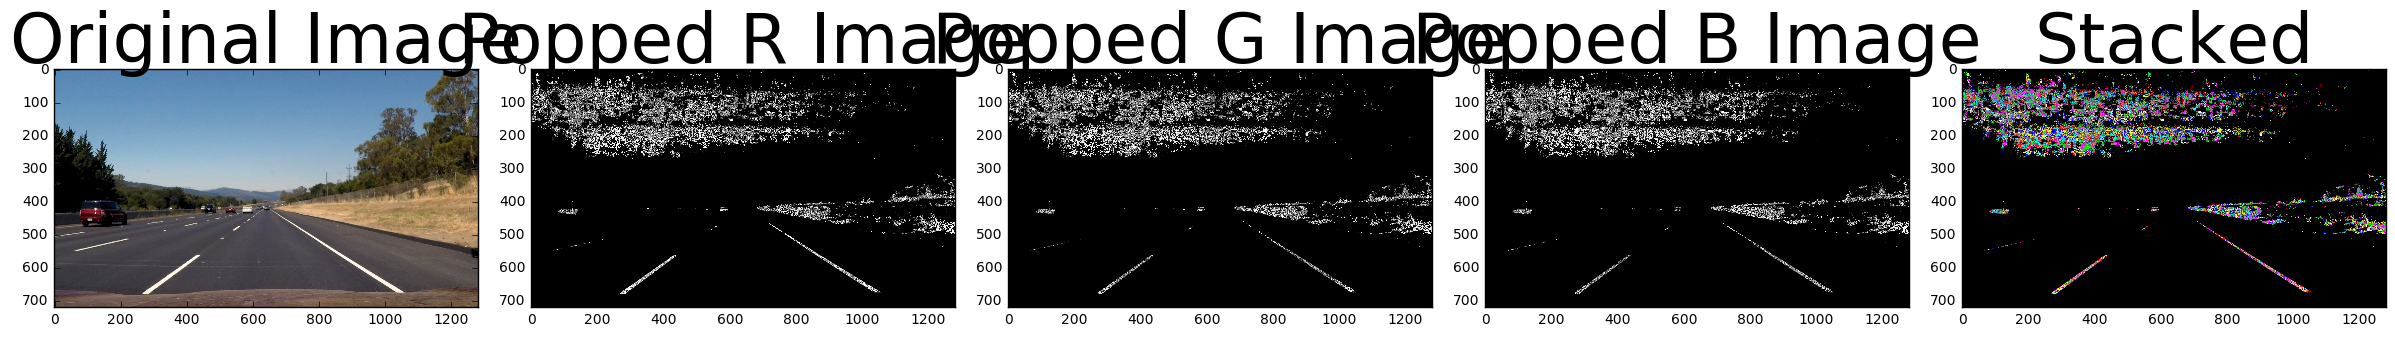

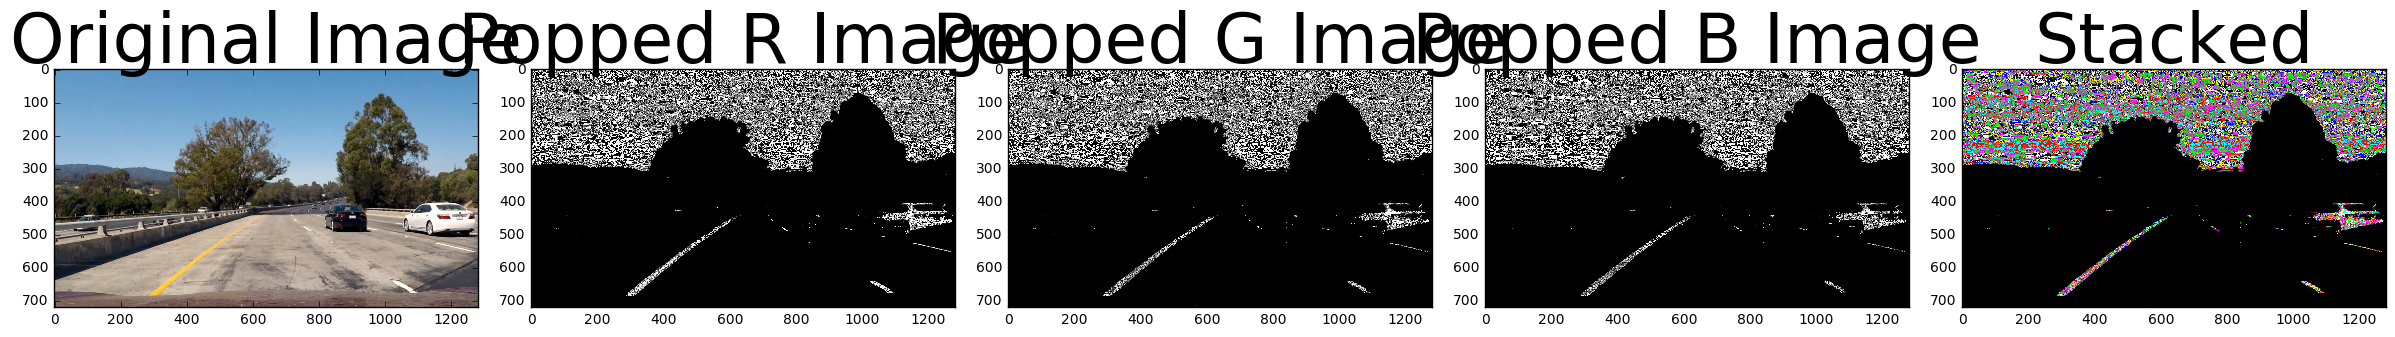

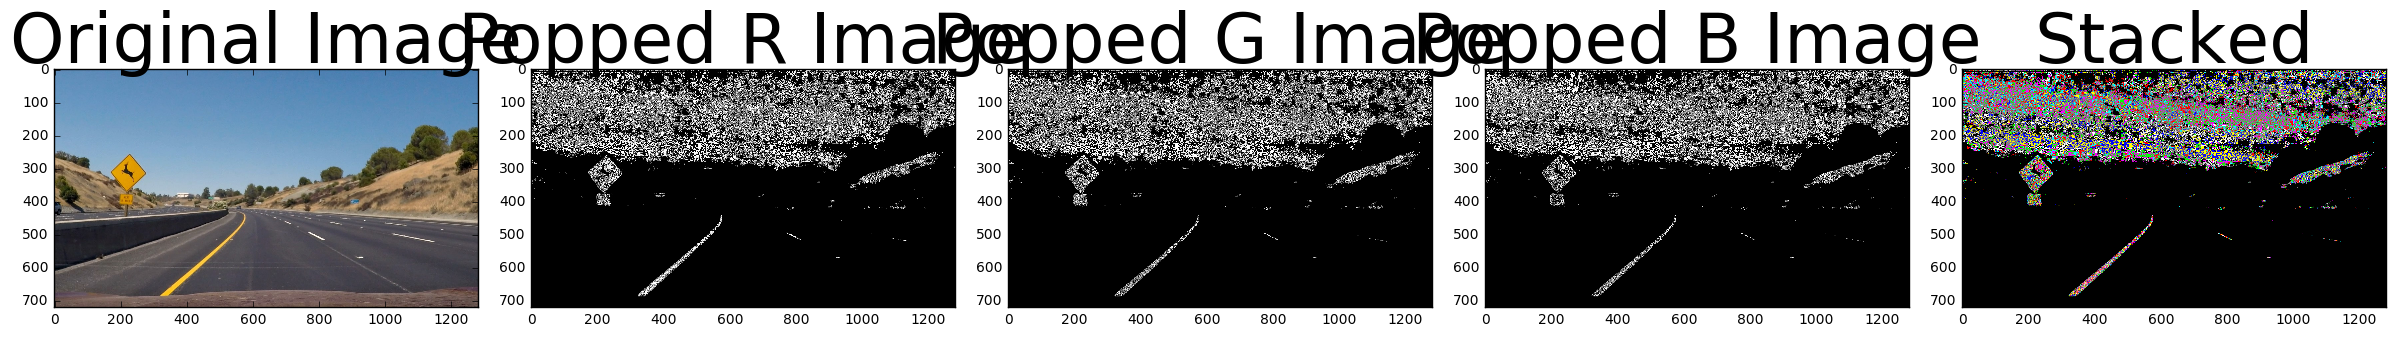

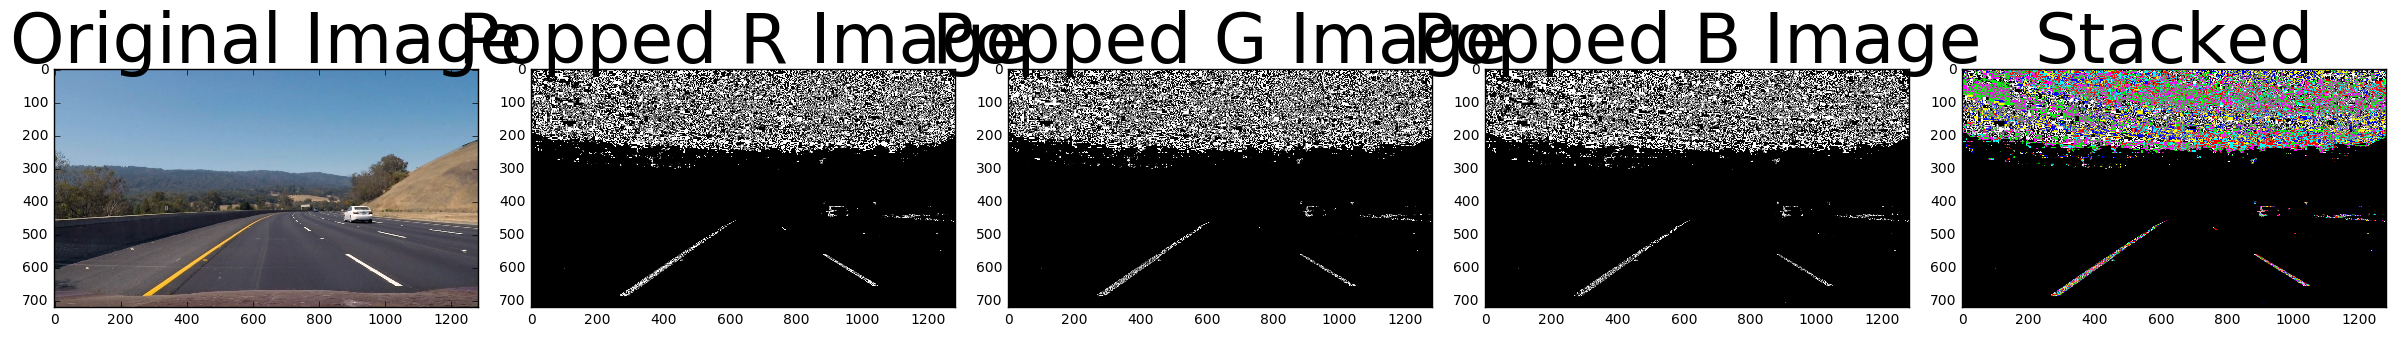

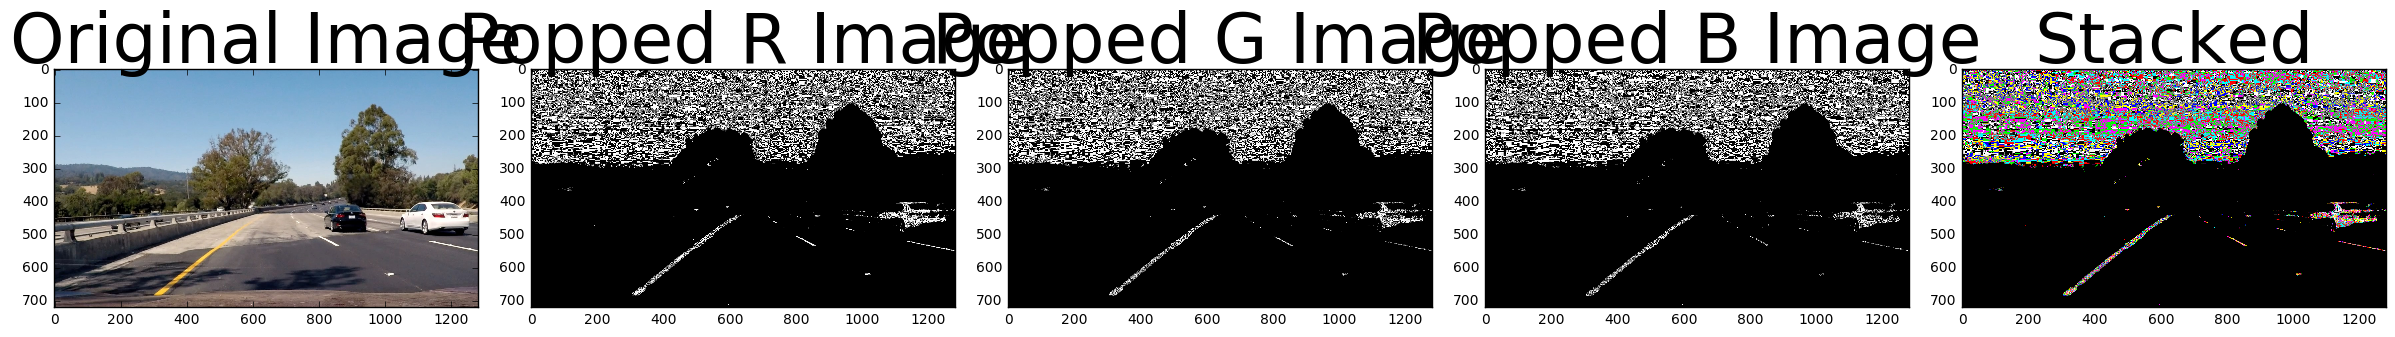

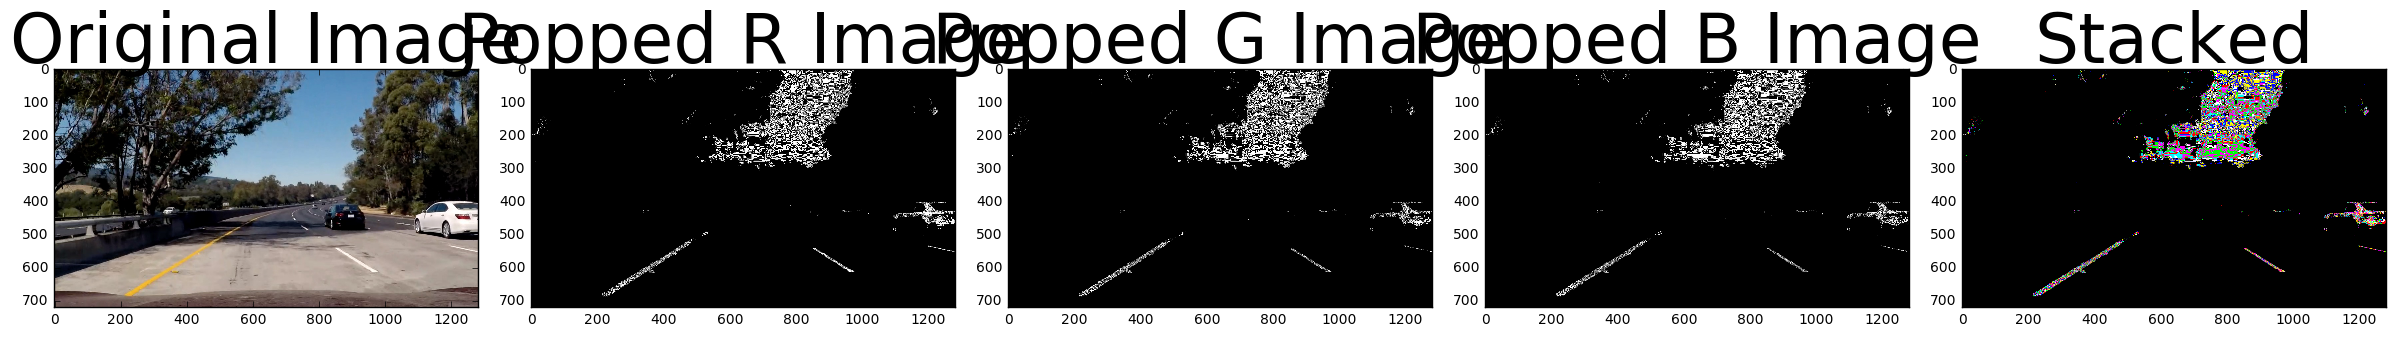

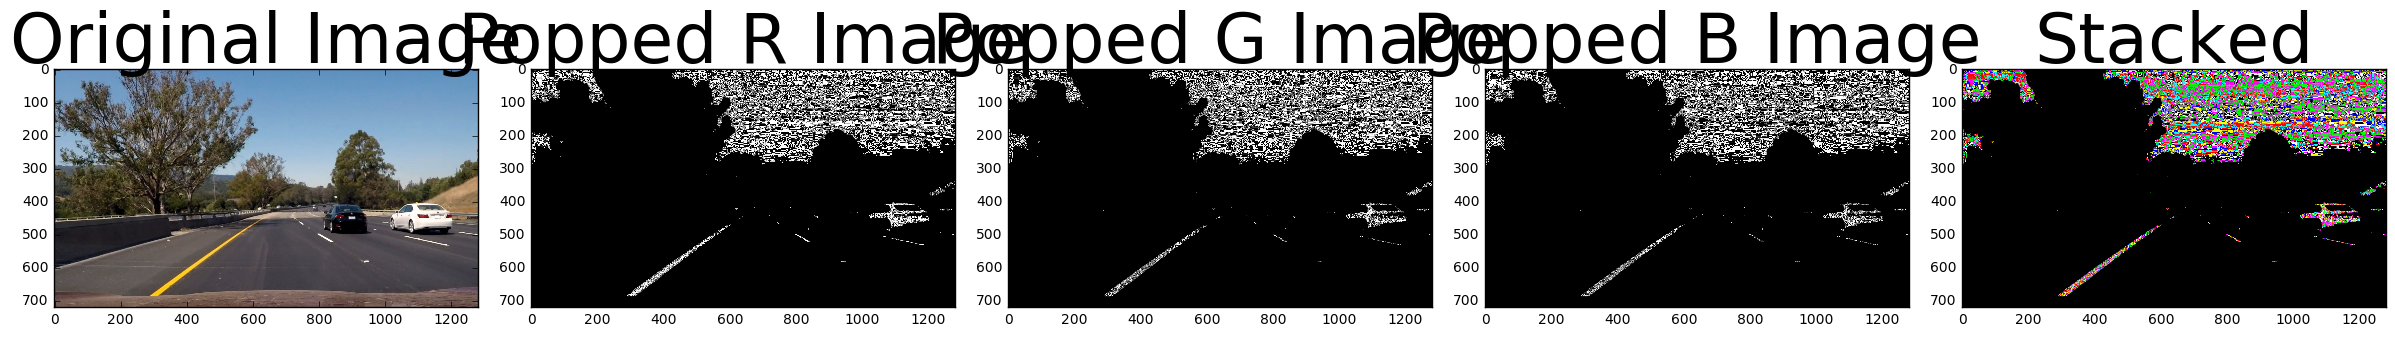

In [16]:
images = glob.glob(img_path+'*.jpg')
for fname in images:
    c_img_raw = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB) #CAUTION: cv2.imread reads in BGR

    b_color = color_select(c_img_raw, sthresh=(100, 255), vthresh=(100, 255))
    
    c_img_pop_R = 255*cv2.bitwise_and(c_img_raw[:,:,0], b_color)
    c_img_pop_G = 255*cv2.bitwise_and(c_img_raw[:,:,1], b_color)
    c_img_pop_B = 255*cv2.bitwise_and(c_img_raw[:,:,2], b_color)
    
    c_new = np.dstack((c_img_pop_R, c_img_pop_G, c_img_pop_B))

    # Plot the result
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(c_img_raw)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(c_img_pop_R, cmap='gray')
    ax2.set_title('Popped R Image', fontsize=50)    
    ax3.imshow(c_img_pop_G, cmap='gray')
    ax3.set_title('Popped G Image', fontsize=50)    
    ax4.imshow(c_img_pop_B, cmap='gray')
    ax4.set_title('Popped B Image', fontsize=50)    
    ax5.imshow(c_new)
    ax5.set_title('Stacked', fontsize=50)        